## Assignment 3

### A3.0 New kernel_module code
In the terminal, call `insmod CPUCtr.ko` to insert the CPU Counter code. Verify it was inserted for both CPUs by calling `dmesg | tail`. The CPU Counter code was developed in Lab 3

### A3.1 Access PMU from Python

In [1]:
import ctypes
import multiprocessing
import os
import time

In [2]:
_libct = ctypes.CDLL('./libcycletime.so')

In [3]:
_libct.init_counters(1,0)

1

In [4]:
_libct.init_counters(1,0)
time1=_libct.get_cyclecount()
time.sleep(1)
time2=_libct.get_cyclecount()

print(f"Elapsed cycles: {time2-time1}")

Elapsed cycles: 6933726


### A3.2 Compare and Gather Data

In [5]:
### Program to calculate the Fibonacci sequence up to n-th term. Provided in Lab3
def recur_fibo(n):
   if n <= 1:
       return n
   else:
       return(recur_fibo(n-1) + recur_fibo(n-2))

In [6]:
### Function to time the recursive fibonacci function in both cycles and "time" module time
def time_fibo(n):
    # Start timer
    _libct.init_counters(1,0)
    starttime=time.time()
    startcount=_libct.get_cyclecount()
    # Run on processor 1
    p1 = multiprocessing.Process(target=recur_fibo, args=[n]) # the first arg defines which CPU to run the 'target' on
    p1.start() # start the process
    os.system(f"taskset -c -p {1} {p1.pid} > /dev/null")
    # Wait for completion
    p1.join()
    stoptime=time.time()
    stopcount=_libct.get_cyclecount()
    return (stopcount - startcount, stoptime - starttime)

In [30]:
# Collect data
iterations=25

data_across_terms={}
for terms in range(2,31,2):
    print(f"Running {terms} terms")
    data=[]
    for iteration in range(iterations):
        data.append(time_fibo(terms))
    data_across_terms[terms]=data
    

Running 2 terms
Running 4 terms
Running 6 terms
Running 8 terms
Running 10 terms
Running 12 terms
Running 14 terms
Running 16 terms
Running 18 terms
Running 20 terms
Running 22 terms
Running 24 terms
Running 26 terms
Running 28 terms
Running 30 terms


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from pynq.ps import Clocks

print(f"Clock rate: {Clocks.cpu_mhz} MHz")

means=[]
stddevs=[]
terms_list=[]
for terms, values in data_across_terms.items():
    arr=np.array(values)
    arr[:,0]=arr[:,0]/(Clocks.cpu_mhz*1000000.0)
    means.append(np.mean(arr, axis=0))
    stddevs.append(np.std(arr, axis=0)/np.sqrt(iterations))
    terms_list.append(terms)

Clock rate: 650.0 MHz


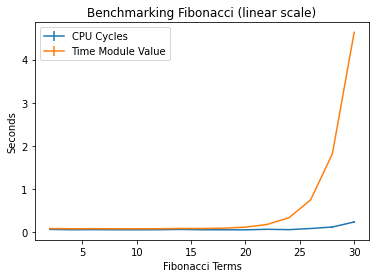

In [32]:
plt.errorbar(terms_list, [mean[0] for mean in means], yerr=[std[0] for std in stddevs], label="CPU Cycles")
plt.errorbar(terms_list, [mean[1] for mean in means], yerr=[std[1] for std in stddevs], label="Time Module Value")

plt.xlabel("Fibonacci Terms")
plt.ylabel("Seconds")
plt.legend()

plt.title("Benchmarking Fibonacci (log scale)")
plt.yscale("log")
# plt.show()
plt.savefig(f"fib_log_{iterations}_iter.png")

plt.clf()

plt.errorbar(terms_list, [mean[0] for mean in means], yerr=[std[0] for std in stddevs], label="CPU Cycles")
plt.errorbar(terms_list, [mean[1] for mean in means], yerr=[std[1] for std in stddevs], label="Time Module Value")

plt.xlabel("Fibonacci Terms")
plt.ylabel("Seconds")
plt.legend()

plt.title("Benchmarking Fibonacci (linear scale)")
plt.yscale("linear")
# plt.show ()
plt.savefig(f"fib_lin_{iterations}_iter.png")